In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%load_ext autotime

time: 296 µs


In [3]:
%cd ..

/Users/rubenbroekx/Documents/Projects/twitter-sentiment-classifier/twitter_sentiment_classifier
time: 1.48 ms


In [4]:
# Necessary to be in root to get access to store
%cd ..

/Users/rubenbroekx/Documents/Projects/twitter-sentiment-classifier
time: 995 µs


# Evaluate

Evaluate the SentimentModel.

In [5]:
import json
import os
import pandas as pd

from twitter_sentiment_classifier.store.loader import fetch_all_tweet_data
from tqdm import tqdm
from collections import Counter

time: 4.6 s


## 1. Load in data

Load in the different datasets (`train`, `test`, and `validation`).

In [6]:
# Fetch all tweet data from S3 (skips automatically if this is already the case)
fetch_all_tweet_data()

time: 777 µs


In [7]:
# Testing
with open(os.path.expanduser('twitter_sentiment_classifier/store/data/tweets_test.jsonl'), 'r') as f:
    annotations_test = [json.loads(line) for line in f.readlines()]
print(f"Loaded in {len(annotations_test)} testing annotations")

Loaded in 3000 testing annotations
time: 45 ms


## 2. Predict

Create predictions for all the test samples.

In [8]:
from twitter_sentiment_classifier.sentiment_model import batch_predict

time: 573 µs


In [9]:
texts = [a['text'] for a in annotations_test]
labels = [a['label'] for a in annotations_test]

time: 1.89 ms


In [10]:
predictions = batch_predict(texts=texts)

Unzipping sentiment-model-classes3.zip...


Special tokens have been added in the vocabulary, make sure the associated word embedding are fine-tuned or trained.
100%|██████████| 94/94 [05:43<00:00,  3.65s/it]

time: 7min 52s


## 3. Evaluate

Evaluate the predictions using the accuracy measure and confusion matrices.

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

from typing import List, Any
from sklearn.metrics import confusion_matrix

time: 614 ms


In [12]:
LABELS = ['NEGATIVE', 'NEUTRAL', 'POSITIVE']

def calc_accuracy(
        labels_true: List[Any],
        labels_pred: List[Any],
        display: bool = False,
):
    """Calculate the accuracy."""
    counter = Counter()
    for true, pred in zip(labels_true, labels_pred):
        assert true in LABELS
        assert pred in LABELS
        counter[true == pred] += 1
    assert counter[True] + counter[False] == len(labels_true)
    
    # Create a response
    response = {
        'n_correct':   counter[True],
        'n_incorrect': counter[False],
        'accuracy':    counter[True] / len(labels_true)
    }
    if display:
        print("\nEvaluation result:")
        print(f" -   Correctly classified: {response['n_correct']}")
        print(f" - Incorrectly classified: {response['n_incorrect']}")
        print(f" -               Accuracy: {round(100 * response['accuracy'], 2)}%")
    return response

def calc_confusion_matrix(
        labels_true: List[Any],
        labels_pred: List[Any],
        display: bool = False,
):
    """Print the confusion matrix."""
    matrix = confusion_matrix(labels_true, labels_pred, labels=LABELS)
    
    if display:
        print("\nConfusion matrix:")
        print_confusion_matrix(matrix)
    return matrix


def calc_confusion_matrix_relative(
        labels_true: List[Any],
        labels_pred: List[Any],
        display: bool = False,
):
    """Print the confusion matrix."""
    matrix = confusion_matrix(labels_true, labels_pred, labels=LABELS).astype('float64')
    n_label = [len([l for l in labels_true if l == label]) for label in LABELS]
    for x in range(len(LABELS)):
        matrix[:, x] = [round(100 * matrix[y, x] / n_label[y], 2) for y in range(len(LABELS))]
    
    if display:
        print("\nRelative confusion matrix:")
        print_confusion_matrix(matrix)
    return matrix

def print_confusion_matrix(
        matrix,
) -> None:
    """Print the given confusion matrix."""
    print(f"{'':^10s}| NEGATIVE | NEUTRAL  | POSITIVE |")
    for x, abbr in enumerate(LABELS):
        print_divider(len(LABELS) + 2)
        values = [matrix[y, x] for y in range(len(LABELS))]
        values.append(round(sum(values)))
        print(f"{abbr:^10s}|" + '|'.join([f"{str(round(v, 1)):^10s}" if v else f"{'':^10s}" for v in values]))
    print_divider(len(LABELS) + 2)
    print(f"{'':^10s}|" +
          "|".join([f"{str(round(matrix[y, :].sum())):^10s}" for y in range(len(LABELS))]) +
          "|")
    
def print_divider(
        n: int,
        space: int = 10,
):
    """Print a divider-line of the confusion matrix."""
    print('+'.join(['-' * space for _ in range(n)]))
    
def plot_heatmap(matrix, fmt:str='d'):
    """Create a heatmap-plot of the model's confusion."""
    plt.figure(figsize=(5,4))
    sns.heatmap(
        matrix.astype('int' if fmt=='d' else 'float'),
        xticklabels=LABELS,
        yticklabels=LABELS,
        annot=True,
        fmt=fmt
    )

time: 2.15 ms


In [13]:
print("Model accuracy")
accuracy = calc_accuracy(
    labels_true=labels,
    labels_pred=predictions,
    display=True,
)

Model accuracy

Evaluation result:
 -   Correctly classified: 2144
 - Incorrectly classified: 856
 -               Accuracy: 71.47%
time: 2.67 ms


Confusion matrix (expressed in total values)


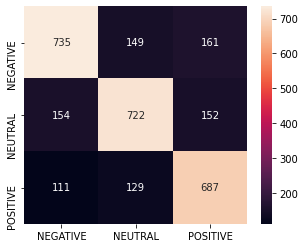

time: 170 ms


In [14]:
print("Confusion matrix (expressed in total values)")
confusion = calc_confusion_matrix(
    labels_true=labels,
    labels_pred=predictions,
    display=False,
).transpose()
plot_heatmap(confusion)

Relative confusion matrix (expressed in percentages)


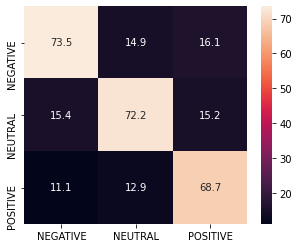

time: 145 ms


In [15]:
print("Relative confusion matrix (expressed in percentages)")
confusion_rel = calc_confusion_matrix_relative(
    labels_true=labels,
    labels_pred=predictions,
    display=False,
).transpose()
plot_heatmap(confusion_rel, fmt='.1f')